In [1]:
import numpy as np
import scipy.optimize
import pandas as pd
import operator
import scipy.io
import scipy
import scipy.sparse
import time
import sys
import os
import matplotlib.pyplot as plt

/home/rilevin/miniconda3/envs/mmort/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'mmort')))
import experiments
import optimization_tools
import evaluation
import utils

In [3]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'ProstateExample_BODY_not_reduced_with_OAR_constraints.mat'))
# data_no_body_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'ProstateExample.mat'))
data = scipy.io.loadmat(data_path)
# data_no_body =  scipy.io.loadmat(data_no_body_path)
Alpha = np.array([0.35, 0.35])
Beta = np.array([0.175, 0.175])
Gamma = np.array([np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35])               
                 ])
Delta = np.array([np.array([0.07, 0.07]),
                  np.array([0.07, 0.07]),
                  np.array([0.175, 0.175]),
                  np.array([0.175, 0.175]),
                  np.array([0.175, 0.175])                
                 ])
modality_names = np.array(['Aphoton', 'Aproton'])

num_body_voxels = 683189
data['Aphoton'][-1] = data['Aphoton'][-1]/num_body_voxels
data['Aproton'][-1] = data['Aproton'][-1]/num_body_voxels

In [4]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

In [5]:
#Max dose for dv constrained organs:
import copy

data_max_dose = copy.deepcopy(data)
data_max_dose['OAR_constraint_types'][data_max_dose['OAR_constraint_types'] == 'dose_volume'] = 'max_dose'
data_max_dose

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

In [6]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

In [7]:
# %%time
# T_list_mult_max, T_mult_max, H_mult_max, alpha_mult_max, gamma_mult_max, B_mult_max, D_mult_max, C_mult_max = experiments.construct_auto_param_solver_input(np.array([43,1]), Alpha, Beta, Gamma, Delta, data_max_dose, modality_names)
# # u_init = 10*np.ones(2289+16358)
# utils.save_obj(T_list_mult_max, 'T_list_mult_max')
# utils.save_obj(T_mult_max, 'T_mult_max')
# utils.save_obj(H_mult_max, 'H_mult_max')
# utils.save_obj(alpha_mult_max, 'alpha_mult_max')
# utils.save_obj(gamma_mult_max, 'gamma_mult_max')
# utils.save_obj(B_mult_max, 'B_mult_max')
# utils.save_obj(D_mult_max, 'D_mult_max')
# utils.save_obj(C_mult_max, 'C_mult_max')

In [8]:
T_list_mult_max = utils.load_obj('T_list_mult_max')
T_mult_max = utils.load_obj('T_mult_max')
H_mult_max = utils.load_obj('H_mult_max')
alpha_mult_max = utils.load_obj('alpha_mult_max')
gamma_mult_max = utils.load_obj('gamma_mult_max')
B_mult_max = utils.load_obj('B_mult_max')
D_mult_max = utils.load_obj('D_mult_max')
C_mult_max = utils.load_obj('C_mult_max')

In [9]:
data_max_dose['num_voxels'][0][1:].sum()

25279

In [10]:
len(C_mult_max)

25279

In [11]:
def generate_dose_volume_input(T_list_mult_max, T_mult_max, H_mult_max, alpha_mult_max, gamma_mult_max, B_mult_max, D_mult_max, C_mult_max, u_mult, N, data, Alpha, Beta, Gamma, Delta, photon_only = False):
    oar_indices = np.split(np.arange(data['Aphoton'].shape[0]), np.cumsum(np.squeeze(data['num_voxels'])[1:]))[:-1]
    dv_oar_names = [str(i[0]) for i in np.squeeze(data['Organ'])[1:][data['OAR_constraint_types'] == 'dose_volume']]
    for i, name in enumerate(dv_oar_names):
        if photon_only:
            _, _, oar_BE, _, oar_photon_BE = evaluation_function_photon(u_mult, N, data, name, Alpha, Beta, Gamma, Delta, 3000, resolution = 500)
            print(oar_BE, oar_photon_BE)
        else:
            _,_,_,_,_, oar_photon_BE, oar_proton_BE = evaluation.evaluation_function(u_mult, N, data, name, Alpha, Beta, Gamma, Delta, 3000, resolution = 500)
            oar_BE = oar_photon_BE + oar_proton_BE
        #Take the low 50% of the voxels, should make this more general to handle arbitrary percentage
        cur_oar_indices_to_max_constrain = np.argsort(oar_BE)[:(oar_BE.shape[0]//2 + oar_BE.shape[0]%2)]
#         constraint = np.array(C_mult_max)[oar_indices[0]]
        cur_oar_number = np.arange(len(oar_indices))[data['OAR_constraint_types'] == 'dose_volume'][i]
        oar_indices[cur_oar_number] = cur_oar_indices_to_max_constrain
    updated_C = [C_mult_max[i] for oar in oar_indices for i in oar]
    updated_H = [H_mult_max[i] for oar in oar_indices for i in oar]
    updated_gamma = [gamma_mult_max[i] for oar in oar_indices for i in oar]
    updated_D = [D_mult_max[i] for oar in oar_indices for i in oar]
    return oar_indices, T_list_mult_max, T_mult_max, updated_H, alpha_mult_max, updated_gamma, B_mult_max, updated_D, updated_C

In [12]:
# %%time
# T_list_mult, T_mult, H_mult, alpha_mult, gamma_mult, B_mult, D_mult, C_mult = experiments.construct_auto_param_solver_input(np.array([43,1]), Alpha, Beta, Gamma, Delta, data, modality_names)
# # u_init = 10*np.ones(2289+16358)
# utils.save_obj(T_list_mult, 'T_list_mult')
# utils.save_obj(T_mult, 'T_mult')
# utils.save_obj(H_mult, 'H_mult')
# utils.save_obj(alpha_mult, 'alpha_mult')
# utils.save_obj(gamma_mult, 'gamma_mult')
# utils.save_obj(B_mult, 'B_mult')
# utils.save_obj(D_mult, 'D_mult')
# utils.save_obj(C_mult, 'C_mult')

In [13]:
T_list_mult = utils.load_obj( 'T_list_mult')
T_mult = utils.load_obj('T_mult')
H_mult = utils.load_obj('H_mult')
alpha_mult = utils.load_obj('alpha_mult')
gamma_mult = utils.load_obj('gamma_mult')
B_mult = utils.load_obj('B_mult')
D_mult = utils.load_obj('D_mult')
C_mult = utils.load_obj('C_mult')

In [42]:
#Assuming N>0, and two-modality case
N = np.array([43, 1])
Rx = 190#80#190#190 160 120 80
LHS1 = T_list_mult[0]
LHS2 = T_list_mult[1]
RHS1 = np.array([Rx/np.sum(N)]*LHS1.shape[0])
RHS2 = np.array([Rx/np.sum(N)]*LHS2.shape[0])

u1_guess = scipy.optimize.lsq_linear(LHS1, RHS1, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-2, max_iter=30, verbose=1).x
u2_guess = scipy.optimize.lsq_linear(LHS2, RHS2, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-2, max_iter=30, verbose=1).x

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.4276e+00, final cost 8.3652e-01, first-order optimality 2.32e-02.
The relative change of the cost function is less than `tol`.
Number of iterations 7, initial cost 6.1541e+00, final cost 4.1297e+00, first-order optimality 4.15e-03.


In [43]:
u_init11 = np.concatenate([u1_guess, u2_guess])
# u_init11 = np.concatenate([u_conv, np.zeros(u2_guess.shape[0])])
eta_0 =  (1/(2*np.max(B_mult)))*0.9 #Initialize eta_0
eta = np.array([eta_0/len(H_mult)]*len(H_mult))*1e-7

In [44]:
#Set up smoothing matrix
len_voxels = data['Aphoton'].shape[0]
beamlet_indices = np.split(np.arange(len_voxels), np.cumsum(np.squeeze(data['num_beamlets'])))[:-1] 
beams = [data['beamlet_pos'][i] for i in beamlet_indices]
S = utils.construct_smoothing_matrix(beams, eps = 5)
S = S.toarray()
StS = S.T.dot(S)
lambda_smoothing = 5#1e-3 #1e-2

(480, 2)
(405, 2)
(497, 2)
(493, 2)
(414, 2)


In [46]:
%%time
#Redo smoothing, add it with None
#Multi-modality optimal
u_mult_smoothed, eta_0_mult_smoothed, eta_mult_smoothed, auto_param_obj_history_mult_smoothed, auto_param_relaxed_obj_history_mult_smoothed = optimization_tools.solver_auto_param(u_mult_smoothed, S, StS, lambda_smoothing, T_mult, H_mult, alpha_mult, gamma_mult, B_mult, D_mult, C_mult, eta_step = 0.1, ftol = 1e-3, max_iter = 50, verbose = 1, eta = eta, eta_0 = eta_0)
# utils.save_obj(u_mult_smoothed, 'u_mult_smoothed')
# utils.save_obj(eta_0_mult_smoothed, 'eta_0_mult_smoothed')
# utils.save_obj(eta_mult_smoothed, 'eta_mult_smoothed')
# utils.save_obj(auto_param_obj_history_mult_smoothed, 'auto_param_obj_history_mult_smoothed')
# utils.save_obj(auto_param_relaxed_obj_history_mult_smoothed, 'auto_param_relaxed_obj_history_mult_smoothed')

wi update took: 3.247189998626709
      fun: 976096776569.9358
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.92007825e+07, 1.30305887e+07, 8.43691373e+06, ...,
       8.55112143e+03, 8.55568550e+03, 8.56143660e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 1
   status: 0
  success: True
        x: array([ 0.9715774 ,  0.67951959,  0.91434743, ..., 63.72950316,
       60.85789906, 57.28900472])
u update took: 0.8138880729675293
    iter = 1, stopping criterium:2169153011441.6594, OBJ -21692490237.806118
    This iteration took: 5.361870050430298
wi update took: 2.9832100868225098
      fun: 976153536819.1974
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.60370139e+07, -1.13125562e+07, -9.36281625e+06, ...,
        3.74479453e+03,  3.81749356e+03,  3.88970058e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 2
   status: 0
  su

    iter = 11, stopping criterium:0.025009529294458013, OBJ -41636328932.318985
    This iteration took: 14.917687177658081
wi update took: 2.8783419132232666
      fun: 1626317394.3433583
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-13863985.29602051,   1870839.42480469,  -1898078.21838379, ...,
       -22096401.5493927 , -21988169.83120728, -21884435.63134766])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 58
      nit: 51
   status: 1
  success: False
        x: array([ 0.98398807,  0.67377076,  0.91036034, ..., 63.62196721,
       60.75555031, 57.19305662])
u update took: 10.426369428634644
    iter = 12, stopping criterium:0.05928140008054628, OBJ -45166050917.24983
    This iteration took: 14.660957336425781
wi update took: 2.9567041397094727
      fun: 2064673910.9993715
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-18715594.51293945,   4945618.04223633,  -2699465.52642822, ...,
   

    iter = 24, stopping criterium:0.017969149235556793, OBJ -66977906054.034065
    This iteration took: 26.577415704727173
wi update took: 3.324509620666504
      fun: 3786114223.1589823
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-12214395.11791992,  -3080274.14892578,  -3544786.81524658, ...,
        -1909118.72434998,  -1899028.95623779,  -1889333.1786499 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 47
   status: 0
  success: True
        x: array([ 1.00479905,  0.67523484,  0.91343473, ..., 63.51906499,
       60.65792509, 57.10201594])
u update took: 9.385643720626831
    iter = 25, stopping criterium:0.0055288012409725395, OBJ -67302929628.509056
    This iteration took: 13.966224193572998
wi update took: 2.9506893157958984
      fun: 3497566725.752781
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9599208.0916748 , -1934425.01184082, -2889736.27471924, ...,
   

    iter = 37, stopping criterium:0.004762602969957144, OBJ -73485947583.19304
    This iteration took: 9.120823860168457
wi update took: 3.301527500152588
      fun: 4101870200.954449
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9499287.66271973,  2668707.24060059,  2715963.72369385, ...,
        2825393.20896912,  2808215.81213379,  2791675.96966553])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 200
      nit: 191
   status: 1
  success: False
        x: array([ 1.08785087,  0.6875028 ,  0.94373327, ..., 63.48068836,
       60.62218221, 57.06957213])
u update took: 35.148937702178955
    iter = 38, stopping criterium:0.0026453595773122955, OBJ -73893793245.51804
    This iteration took: 40.11265778541565
wi update took: 3.291846752166748
      fun: 4287623772.3718457
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-13058975.13427734,   2631584.98779297,   2200953.71551514, ...,
         -2

    iter = 4, stopping criterium:0.017811489426291606, OBJ -80418353935.74734
    This iteration took: 15.244395017623901
wi update took: 3.471139430999756
      fun: 184100286.78902665
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7081314.71923828, -2688529.94958496, -4502426.03479004, ...,
       -3710802.28659058, -3691517.92041016, -3673002.02674866])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 58
      nit: 50
   status: 1
  success: False
        x: array([ 1.15735993,  0.69428736,  0.95579202, ..., 63.44499858,
       60.5892096 , 57.04000233])
u update took: 10.040586948394775
    iter = 5, stopping criterium:0.016909145020501004, OBJ -81703567898.65561
    This iteration took: 15.246711015701294
wi update took: 3.2796847820281982
      fun: 163168084.7321606
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2008284.44262695,  1050147.23022461, -1600777.50646973, ...,
       -3598832.

    iter = 17, stopping criterium:0.010769979643016946, OBJ -93881962388.98643
    This iteration took: 16.34853482246399
wi update took: 3.360106945037842
      fun: 335526257.7739545
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3767452.98156738, -1145578.63586426, -4849303.73425293, ...,
       -1241287.28218079, -1236890.24035645, -1232701.8828125 ])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 79
      nit: 69
   status: 1
  success: False
        x: array([ 1.15979414,  0.69422806,  0.9576734 , ..., 63.41010817,
       60.55603946, 57.00897699])
u update took: 14.235692739486694
    iter = 18, stopping criterium:0.0068079829442183265, OBJ -94406352700.07977
    This iteration took: 19.30330729484558
wi update took: 3.329672336578369
      fun: 187642272.21179023
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5148589.84716797, -3369480.49328613, -4025178.78601074, ...,
       -2364120.

    iter = 30, stopping criterium:0.005203175152224892, OBJ -102910445291.88692
    This iteration took: 33.26045250892639
wi update took: 3.537240982055664
      fun: 419785649.78607166
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3615870.28808594, -1109000.4822998 ,  -650847.39556885, ...,
        1306186.73291016,  1295117.96792603,  1284410.38465881])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 173
      nit: 140
   status: 1
  success: False
        x: array([ 1.18063731,  0.69687042,  0.96304618, ..., 63.38178936,
       60.52942203, 56.98448856])
u update took: 30.097299575805664
    iter = 31, stopping criterium:0.0035338524680286346, OBJ -103234186618.13515
    This iteration took: 35.15412998199463
wi update took: 3.4455862045288086
      fun: 518593573.03731614
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7587956.90332031,  -899056.79382324, -1758107.71337891, ...,
         7

    iter = 10, stopping criterium:0.0015431503341069525, OBJ -105064105326.61569
    This iteration took: 15.449573040008545
wi update took: 3.7609381675720215
      fun: 46041623.44396998
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2646559.89367676,   -36346.71704102,   -11988.55151367, ...,
        -315320.94578552,  -313624.2545929 ,  -311990.76695251])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 55
      nit: 50
   status: 1
  success: False
        x: array([ 1.19498863,  0.69722115,  0.96469007, ..., 63.37738171,
       60.52525184, 56.98061502])
u update took: 9.838297843933105
    iter = 11, stopping criterium:0.0015129282145942972, OBJ -105217840798.66615
    This iteration took: 15.057725667953491
wi update took: 3.485576868057251
      fun: 44458667.44419806
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1935702.62805176,   589724.59436035,   480925.31134033, ...,
        -313

    iter = 23, stopping criterium:0.0010510820159557342, OBJ -106776019867.41908
    This iteration took: 22.253464698791504
wi update took: 3.484081745147705
      fun: 47962093.0063505
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1902966.54772949,   436156.31555176,     8518.63317871, ...,
         224204.79545593,   221420.12727356,   218720.62261963])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 103
      nit: 97
   status: 1
  success: False
        x: array([ 1.200162  ,  0.69658882,  0.96535586, ..., 63.37343697,
       60.52152423, 56.97715898])
u update took: 18.36980891227722
    iter = 24, stopping criterium:0.0009959319909551715, OBJ -106878967561.26364
    This iteration took: 23.24743914604187
# of violated constr: 0
Opt Iter 4
wi update took: 4.057298183441162
      fun: 34877444.153617464
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2122415.27685547,   426974.93481445,   

In [48]:
u_mult_non_smoothed = utils.load_obj('u_mult_non_smoothed')
# utils.save_obj(eta_0_mult_smoothed, 'eta_0_mult_non_smoothed')
# utils.save_obj(eta_mult_smoothed, 'eta_mult_non_smoothed')
# utils.save_obj(auto_param_obj_history_mult_smoothed, 'auto_param_obj_history_mult_non_smoothed')
# utils.save_obj(auto_param_relaxed_obj_history_mult_smoothed, 'auto_param_relaxed_obj_history_mult_non_smoothed')

In [50]:
def organ_photon_matrix(organ_name):
    organ_names = [str(i[0]) for i in np.squeeze(data['Organ'])]
    organ_number = organ_names.index(organ_name)
    organ_number_no_target = organ_number-1
    len_voxels = data['Aphoton'].shape[0]
    #[:-1] because we don't wabt the last isolated voxel
    organ_indices = np.split(np.arange(len_voxels), np.cumsum(np.squeeze(data['num_voxels'])))[:-1]
    #Do this in per-voxel fashion
    photon_num = data['Aphoton'].shape[1]
#     u_photon = u[:photon_num]
#     u_proton = u[photon_num:]
    organ_Aphoton = data['Aphoton'][organ_indices[organ_number]]
    return organ_Aphoton

In [51]:
# u_mult = utils.load_obj('u_mult')

In [52]:
target_dose_smoothed = organ_photon_matrix('Target').dot(u_mult_smoothed[:organ_photon_matrix('Target').shape[1]])
target_dose_non_smoothed = organ_photon_matrix('Target').dot(u_mult_non_smoothed[:organ_photon_matrix('Target').shape[1]])

In [53]:
np.max(target_dose_smoothed)/np.min(target_dose_smoothed)

234.2148250787106

In [54]:
np.max(target_dose_non_smoothed)/np.min(target_dose_non_smoothed)

212.90564817059058

In [56]:
u, obj_history, relaxed_obj_history = optimization_tools.solver(u_mult_smoothed, S, StS, lambda_smoothing,  eta_0_mult_smoothed, eta_mult_smoothed, T_mult, H_mult, alpha_mult, gamma_mult, B_mult, D_mult, C_mult, ftol = 1e-3, max_iter = 50, verbose = 1)

wi update took: 3.842231273651123
      fun: 31863913.167730376
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1733022.62316895,   413065.85986328,   177784.6383667 , ...,
          12905.27204895,    12927.3870697 ,    12952.44393921])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 53
      nit: 50
   status: 1
  success: False
        x: array([ 1.2009999 ,  0.69640772,  0.96531176, ..., 63.37333367,
       60.52142565, 56.97706631])
u update took: 8.808641195297241
    iter = 1, stopping criterium:1069074237684.6118, OBJ -106935031862.27708
    This iteration took: 14.358184099197388
wi update took: 3.4476404190063477
      fun: 30622878.623819016
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1535531.2244873 ,   438402.28259277,   199388.769104  , ...,
          16013.61625671,    16007.43893433,    16005.22019958])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 54
  

In [28]:
%%time
#Now with DVH constraints:
oar_indices, T_list_mult_max, T_mult_max, updated_H, alpha_mult_max, updated_gamma, B_mult_max, updated_D, updated_C = generate_dose_volume_input(T_list_mult_max, T_mult_max, H_mult_max, alpha_mult_max, gamma_mult_max, B_mult_max, D_mult_max, C_mult_max, u_mult, N, data, Alpha, Beta, Gamma, Delta)

eta_0 =  (1/(2*np.max(B_mult_max)))*0.9 #Initialize eta_0
eta = np.array([eta_0/len(updated_H)]*len(updated_H))*1e-7
lambda_smoothing = 1e-3

u_mult_dv, eta_0_mult_dv, eta_mult_dv, auto_param_obj_history_mult_dv, auto_param_relaxed_obj_history_mult_dv = optimization_tools.solver_auto_param(u_mult, S, StS, lambda_smoothing, T_mult_max, updated_H, alpha_mult_max, updated_gamma, B_mult_max, updated_D, updated_C, eta_step = 0.9, ftol = 1e-3, max_iter = 300, verbose = 1, eta = eta, eta_0 = eta_0)
# utils.save_obj(u_mult_dv, 'u_mult_dv')
# utils.save_obj(eta_0_mult_dv, 'eta_0_mult_dv')
# utils.save_obj(eta_mult_dv, 'eta_mult_dv')
# utils.save_obj(auto_param_obj_history_mult_dv, 'auto_param_obj_history_mult_dv')
# utils.save_obj(auto_param_relaxed_obj_history_mult_dv, 'auto_param_relaxed_obj_history_mult_dv')

NameError: name 'u_mult' is not defined

In [287]:
-718430.6657765203/-701670.1523705856

1.0238865987805088

In [290]:
np.e**(-718430.6657765203)

0.0

In [285]:
utils.save_obj(T_list_mult_max, 'T_list_mult_max_upd')
utils.save_obj(T_mult_max, 'T_mult_max_upd')
utils.save_obj(updated_H, 'H_mult_max_upd')
utils.save_obj(alpha_mult_max, 'alpha_mult_max_upd')
utils.save_obj(updated_gamma, 'gamma_mult_max_upd')
utils.save_obj(B_mult_max, 'B_mult_max_upd')
utils.save_obj(updated_D, 'D_mult_max_upd')
utils.save_obj(updated_C, 'C_mult_max_upd')

In [255]:
%%time
#This is wrong, should start from u_mul bc of the low 50% voxels
#Now with DVH constraints, from initial guess
oar_indices, T_list_mult_max, T_mult_max, updated_H, alpha_mult_max, updated_gamma, B_mult_max, updated_D, updated_C = generate_dose_volume_input(T_list_mult_max, T_mult_max, H_mult_max, alpha_mult_max, gamma_mult_max, B_mult_max, D_mult_max, C_mult_max, u_mult, N, data, Alpha, Beta, Gamma, Delta)

u_init11 = np.concatenate([u1_guess, u2_guess])
eta_0 =  (1/(2*np.max(B_mult_max)))*0.9 #Initialize eta_0
eta = np.array([eta_0/len(updated_H)]*len(updated_H))*1e-7

u_mult_dv_from_init, eta_0_mult_dv_from_init, eta_mult_dv_from_init, auto_param_obj_history_mult_dv_from_init, auto_param_relaxed_obj_history_mult_dv_from_init = optimization_tools.solver_auto_param(u_init11, T_mult_max, updated_H, alpha_mult_max, updated_gamma, B_mult_max, updated_D, updated_C, eta_step = 0.9, ftol = 1e-3, max_iter = 300, verbose = 1, eta = eta, eta_0 = eta_0)
utils.save_obj(u_mult_dv_from_init, 'u_mult_dv_from_init')
utils.save_obj(eta_0_mult_dv_from_init, 'eta_0_mult_dv_from_init')
utils.save_obj(eta_mult_dv_from_init, 'eta_mult_dv_from_init')
utils.save_obj(auto_param_obj_history_mult_dv_from_init, 'auto_param_obj_history_mult_dv_from_init')
utils.save_obj(auto_param_relaxed_obj_history_mult_dv_from_init, 'auto_param_relaxed_obj_history_mult_dv_from_init')

wi update took: 3.9141507148742676
      fun: 29265972194546.164
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.60317114e+09, -2.21505243e+09, -2.13233200e+09, ...,
        1.63783674e+09,  2.00565256e+09,  2.23397822e+09])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 55
      nit: 50
   status: 1
  success: False
        x: array([ 0.18336524,  0.19700535,  0.16550113, ..., 63.59275903,
       60.71285704, 57.13810252])
u update took: 4.911546945571899
    iter = 1, stopping criterium:585318000695944.0, OBJ -391164.549104332
    This iteration took: 9.562774181365967
wi update took: 2.239891529083252
      fun: 6088834193639.044
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.37216574e+09, -2.24710437e+09, -2.14869592e+09, ...,
       -3.17326640e+07, -3.42862512e+07, -1.58166738e+07])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 52
      nit: 50
   status: 1
  su

wi update took: 1.406834602355957
      fun: 108339296764.00711
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.06602820e+08, -1.45401254e+08, -9.67494164e+07, ...,
       -3.50873306e+06, -4.02920986e+06, -4.05454300e+06])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 59
      nit: 56
   status: 1
  success: False
        x: array([ 0.60071886,  0.6058861 ,  0.48368123, ..., 63.52001367,
       60.64421034, 57.07239941])
u update took: 4.687361717224121
    iter = 14, stopping criterium:0.15820993855283827, OBJ -264361.4855688516
    This iteration took: 6.86093544960022
wi update took: 1.4317970275878906
      fun: 92279680973.91408
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.97788772e+08, -1.31882409e+08, -8.78333556e+07, ...,
       -6.28964044e+06, -6.91929622e+06, -7.04990712e+06])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 62
      nit: 58
   status: 1
 

    iter = 26, stopping criterium:0.1061811869763306, OBJ -255180.4880686156
    This iteration took: 11.365312337875366
wi update took: 1.3868861198425293
      fun: 20099961663.004745
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-55418724.07836914, -18996873.93359375, -18380489.3449707 , ...,
        -1238544.43109131,  -1332733.28137207,  -1350421.19268799])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 121
      nit: 114
   status: 1
  success: False
        x: array([ 0.89852285,  0.74201017,  0.60384887, ..., 63.50339645,
       60.62893469, 57.05828025])
u update took: 9.76206636428833
    iter = 27, stopping criterium:0.10568150158228168, OBJ -254577.81653318222
    This iteration took: 11.825841665267944
wi update took: 1.313105583190918
      fun: 17986101692.060646
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-50654204.93579102, -17114287.6027832 , -14083721.10241699, ...,
      

    iter = 39, stopping criterium:0.08543385612341349, OBJ -251048.94160986145
    This iteration took: 17.15282130241394
wi update took: 1.3633532524108887
      fun: 6217745204.118613
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-39503627.56640625, -12698279.91467285, -11980759.44421387, ...,
          101513.8168335 ,     61541.80822754,     41949.9710083 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 59
      nit: 55
   status: 0
  success: True
        x: array([ 1.27645817,  0.86139435,  0.72700516, ..., 63.49840261,
       60.62470261, 57.05458666])
u update took: 4.645185470581055
    iter = 40, stopping criterium:0.06556568831931274, OBJ -250992.74358526262
    This iteration took: 6.684370517730713
wi update took: 1.2447636127471924
      fun: 5756290913.151407
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9397877.55249023,  -421487.81640625, -1977614.03381348, ...,
        

    iter = 52, stopping criterium:0.052654213049240305, OBJ -249929.6782426389
    This iteration took: 6.313974142074585
wi update took: 1.3252346515655518
      fun: 2659209762.4530034
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-20022474.82739258,  -6949971.52893066,  -4821380.59521484, ...,
         -256930.20611572,   -293166.87890625,   -311602.86395264])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 49
      nit: 46
   status: 0
  success: True
        x: array([ 1.46335901,  0.91770522,  0.7733564 , ..., 63.49654036,
       60.62310761, 57.05318099])
u update took: 3.420621871948242
    iter = 53, stopping criterium:0.05153560242648448, OBJ -249898.45357806887
    This iteration took: 5.373895883560181
wi update took: 1.2962663173675537
      fun: 2524119404.9838586
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-20811281.55444336,  -7679869.9765625 ,  -5325431.89575195, ...,
   

    iter = 65, stopping criterium:0.04693083268929623, OBJ -249228.78398495007
    This iteration took: 4.895331144332886
wi update took: 1.3433313369750977
      fun: 1239129627.4464636
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.29502754e+06, -3.18824882e+06, -1.13948822e+06, ...,
        5.36204224e+03, -7.76761420e+03, -1.41856573e+04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 47
      nit: 44
   status: 0
  success: True
        x: array([ 1.58807756,  0.96225308,  0.79805499, ..., 63.49497606,
       60.62185183, 57.05216116])
u update took: 3.48003888130188
    iter = 66, stopping criterium:0.04718071855714158, OBJ -249209.09800163124
    This iteration took: 5.527092218399048
wi update took: 1.4026098251342773
      fun: 1182546672.9509122
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-11778812.38305664,  -5389094.48962402,  -3026977.15686035, ...,
          -14218.64080

    iter = 78, stopping criterium:0.05442313979717651, OBJ -248918.41235092783
    This iteration took: 6.501521825790405
wi update took: 1.5558602809906006
      fun: 655108696.2426996
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6969212.72045898, -3615055.42089844, -1880042.56542969, ...,
         -93658.46905518,  -106852.79241943,  -113561.90112305])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 50
   status: 0
  success: True
        x: array([ 1.61637602,  0.97507978,  0.80330539, ..., 63.49420892,
       60.62119211, 57.05159447])
u update took: 4.058645963668823
    iter = 79, stopping criterium:0.04426588326755608, OBJ -248904.17012633575
    This iteration took: 6.3729448318481445
wi update took: 1.3600342273712158
      fun: 620989418.9464455
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 505435.27856445,  909823.82250977,  807176.02746582, ...,
       -216669.5

    iter = 91, stopping criterium:0.04118998649529693, OBJ -248664.6338192636
    This iteration took: 5.60591459274292
wi update took: 1.384826898574829
      fun: 352680164.8434429
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4771367.23828125, -2454787.96020508, -1220747.98254395, ...,
         -63368.86743164,   -71791.5111084 ,   -76271.6206665 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 48
   status: 0
  success: True
        x: array([ 1.65162598,  0.99227826,  0.81010453, ..., 63.49360308,
       60.62069042, 57.05117702])
u update took: 3.8735647201538086
    iter = 92, stopping criterium:0.04071844262632754, OBJ -248655.24329107525
    This iteration took: 5.91823148727417
wi update took: 1.3338193893432617
      fun: 338727431.2289471
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4645267.92407227, -2327227.21655273, -1127878.23242188, ...,
         -74420.8

    iter = 104, stopping criterium:0.03779434988248973, OBJ -248541.48727358668
    This iteration took: 6.093512773513794
wi update took: 1.276745319366455
      fun: 210716315.91048303
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3875555.07421875, -2022488.49023438, -1046861.08056641, ...,
         -63967.89862061,   -70252.66516113,   -73660.11639404])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 54
   status: 0
  success: True
        x: array([ 1.6599131 ,  0.99640533,  0.81190657, ..., 63.49327271,
       60.62038069, 57.05088835])
u update took: 4.023235559463501
    iter = 105, stopping criterium:0.038053323769755405, OBJ -248534.61776549424
    This iteration took: 5.993329763412476
wi update took: 1.2485229969024658
      fun: 203215501.68726945
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3287217.30615234, -1549625.35913086,  -639982.45861816, ...,
         -

    iter = 117, stopping criterium:0.03431959518627322, OBJ -248455.74479601398
    This iteration took: 5.033111810684204
wi update took: 1.2972772121429443
      fun: 132781482.91963834
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.65316961e+06, -1.15178300e+06, -3.77992296e+05, ...,
       -2.42584418e+03, -4.72047815e+03, -6.10195349e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 29
   status: 0
  success: True
        x: array([ 1.66635146,  0.99962968,  0.81339762, ..., 63.49288674,
       60.62003641, 57.05058465])
u update took: 2.200443983078003
    iter = 118, stopping criterium:0.03435400508358956, OBJ -248451.73375322728
    This iteration took: 4.178171873092651
wi update took: 1.3024544715881348
      fun: 128641062.7701298
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.77276622e+06, -1.39290490e+06, -6.58724262e+05, ...,
        5.27425586e+03,  3.60

    iter = 130, stopping criterium:0.0318356926940287, OBJ -248404.51157679147
    This iteration took: 5.009284734725952
wi update took: 1.2407915592193604
      fun: 88516047.4329901
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -36648.23608398, -129141.84899902,   37763.35192871, ...,
         31746.46862793,   37668.55218506,   41946.074646  ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 278
      nit: 266
   status: 0
  success: True
        x: array([ 1.67324695,  1.00312497,  0.81477831, ..., 63.49282551,
       60.6199802 , 57.05053286])
u update took: 21.196698427200317
    iter = 131, stopping criterium:0.03935993769503468, OBJ -248401.39183042577
    This iteration took: 23.137832164764404
wi update took: 1.2826004028320312
      fun: 85460883.34423825
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2146502.28637695, -1190168.94641113,  -556020.75354004, ...,
         -24544.

    iter = 143, stopping criterium:0.03040652816469318, OBJ -248370.29751418743
    This iteration took: 5.58826208114624
wi update took: 1.321692705154419
      fun: 62856555.9333972
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1680481.03710938,  -860656.1628418 ,  -385873.11706543, ...,
         -33174.00646973,   -35827.32196045,   -37415.96099854])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 40
      nit: 34
   status: 0
  success: True
        x: array([ 1.67357348,  1.00328549,  0.81485146, ..., 63.49267793,
       60.61984002, 57.05040156])
u update took: 2.801180362701416
    iter = 144, stopping criterium:0.0304220228154856, OBJ -248368.11516044594
    This iteration took: 4.841028213500977
wi update took: 1.2976434230804443
      fun: 61363561.565064855
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1242916.68774414,  -501107.84057617,   -68196.65722656, ...,
         -35487

    iter = 156, stopping criterium:0.030088350385842552, OBJ -248344.34896761127
    This iteration took: 5.649057626724243
wi update took: 1.230053424835205
      fun: 46655809.98858843
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1252762.57910156,  -609299.05090332,  -189674.56567383, ...,
         -31138.02789307,   -33488.1126709 ,   -34893.63299561])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 37
      nit: 31
   status: 0
  success: True
        x: array([ 1.6737952 ,  1.00339596,  0.81490178, ..., 63.49255783,
       60.61972587, 57.0502946 ])
u update took: 3.141906261444092
    iter = 157, stopping criterium:0.029558224363717835, OBJ -248342.6639452733
    This iteration took: 5.007438659667969
wi update took: 1.2619881629943848
      fun: 45674258.87538039
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1582384.11865234,  -881206.35119629,  -447754.48144531, ...,
         -35

    iter = 169, stopping criterium:0.02949452324488243, OBJ -248323.78457846527
    This iteration took: 4.642987251281738
wi update took: 1.3209912776947021
      fun: 35510181.75951371
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1127152.14990234,  -558226.78613281,  -276396.78979492, ...,
         -24499.25640869,   -26352.17175293,   -27463.15960693])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 34
      nit: 30
   status: 0
  success: True
        x: array([ 1.6751607 ,  1.00409855,  0.81518336, ..., 63.49248988,
       60.61966086, 57.05023316])
u update took: 3.2174482345581055
    iter = 170, stopping criterium:0.029600526967445806, OBJ -248322.43453609117
    This iteration took: 5.162015199661255
wi update took: 1.2494328022003174
      fun: 34856087.011891395
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1089491.58105469,  -531734.18798828,  -256276.76000977, ...,
         

    iter = 182, stopping criterium:0.029999013720414226, OBJ -248307.68528264615
    This iteration took: 4.367805480957031
wi update took: 1.2574810981750488
      fun: 28333961.580635574
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-917882.97949219, -395105.74243164, -198318.30249023, ...,
        -22438.51483154,  -24048.05853271,  -25013.04260254])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 29
      nit: 25
   status: 0
  success: True
        x: array([ 1.67526174,  1.00414352,  0.815208  , ..., 63.49240374,
       60.61957885, 57.05015619])
u update took: 2.379364252090454
    iter = 183, stopping criterium:0.029638452708881855, OBJ -248306.6437780759
    This iteration took: 4.396303415298462
wi update took: 1.2719552516937256
      fun: 27890017.78221057
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-924287.50244141, -423701.6986084 , -245963.61828613, ...,
        -27852.5870

    iter = 195, stopping criterium:0.029967740975678232, OBJ -248295.16125154123
    This iteration took: 3.8058555126190186
wi update took: 1.4302012920379639
      fun: 23455338.567635447
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-735274.71044922, -307590.84863281, -184390.3984375 , ...,
        -14836.52044678,  -15921.13012695,  -16567.38415527])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 35
      nit: 32
   status: 0
  success: True
        x: array([ 1.67532642,  1.00416983,  0.81522453, ..., 63.492331  ,
       60.61950954, 57.0500911 ])
u update took: 2.8155336380004883
    iter = 196, stopping criterium:0.03021195892919124, OBJ -248294.2740686275
    This iteration took: 4.8813793659210205
wi update took: 1.2521042823791504
      fun: 23150395.499834485
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-954337.82470703, -452750.91943359, -330637.43774414, ...,
        -13210.4

    iter = 208, stopping criterium:0.030524625641206334, OBJ -248285.08768339537
    This iteration took: 3.615499973297119
wi update took: 1.2816736698150635
      fun: 20091607.795559064
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-635106.49414062, -242038.39624023, -155456.59094238, ...,
        -19187.89672852,  -20472.73797607,  -21239.74224854])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 25
      nit: 23
   status: 0
  success: True
        x: array([ 1.67537035,  1.00418626,  0.81523591, ..., 63.49228749,
       60.61946809, 57.05005216])
u update took: 1.9753227233886719
    iter = 209, stopping criterium:0.03141599095528514, OBJ -248284.39760431516
    This iteration took: 3.883894443511963
wi update took: 1.2507128715515137
      fun: 19879204.757885985
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-586950.88012695, -209647.98681641, -133556.46118164, ...,
        -19649.36

    iter = 221, stopping criterium:0.0338433034849075, OBJ -248276.68082157755
    This iteration took: 4.394728183746338
wi update took: 1.3030452728271484
      fun: 17730527.511147533
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-521725.73144531, -172740.63354492, -128993.29602051, ...,
        -17875.01586914,  -19034.06341553,  -19723.60644531])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 28
      nit: 25
   status: 0
  success: True
        x: array([ 1.67540715,  1.00419866,  0.81524538, ..., 63.49222848,
       60.61941184, 57.0499993 ])
u update took: 2.2346036434173584
    iter = 222, stopping criterium:0.03411471581784159, OBJ -248276.10442031675
    This iteration took: 4.163884162902832
wi update took: 1.2935092449188232
      fun: 17581735.76679852
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-494916.14160156, -162430.44897461, -132735.96630859, ...,
        -17472.51531

    iter = 234, stopping criterium:0.0371289765468871, OBJ -248269.90747242776
    This iteration took: 4.171041488647461
wi update took: 1.402785301208496
      fun: 16097710.808621803
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-534019.58911133, -198774.37194824, -171668.40368652, ...,
        -11152.421875  ,  -11911.83203125,  -12367.01507568])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 16
   status: 0
  success: True
        x: array([ 1.67542734,  1.00420471,  0.81525064, ..., 63.49218294,
       60.6193684 , 57.04995846])
u update took: 1.4826111793518066
    iter = 235, stopping criterium:0.03764752272440973, OBJ -248269.4503374531
    This iteration took: 3.507189989089966
wi update took: 1.2563824653625488
      fun: 15993219.264809066
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-426284.19189453, -124649.64013672,  -96845.31152344, ...,
        -11388.740051

    iter = 247, stopping criterium:0.04435479972345558, OBJ -248264.35334246617
    This iteration took: 3.841160297393799
wi update took: 1.2331688404083252
      fun: 14945833.813313225
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-339949.87890625,  -58926.66186523,  -52537.8503418 , ...,
         -5917.67437744,   -6363.32519531,   -6632.28277588])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 19
      nit: 17
   status: 0
  success: True
        x: array([ 1.67544233,  1.00420889,  0.81525454, ..., 63.49215334,
       60.61934017, 57.04993191])
u update took: 1.4350106716156006
    iter = 248, stopping criterium:0.04554589446324648, OBJ -248263.97628498916
    This iteration took: 3.2810189723968506
wi update took: 1.2494184970855713
      fun: 14873429.534359245
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-413995.44799805, -133693.86486816, -127924.17712402, ...,
         -7197.91

    iter = 260, stopping criterium:0.06326327622198129, OBJ -248259.76651093352
    This iteration took: 3.4715089797973633
wi update took: 1.3953917026519775
      fun: 14130593.110687362
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-265570.78051758,  -14781.25512695,  -23369.3215332 , ...,
         -4988.69750977,   -5361.22241211,   -5585.91992188])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 19
      nit: 17
   status: 0
  success: True
        x: array([ 1.67545343,  1.00421158,  0.81525737, ..., 63.49213019,
       60.61931809, 57.04991115])
u update took: 1.79331374168396
    iter = 261, stopping criterium:0.0660237461578393, OBJ -248259.45020835142
    This iteration took: 3.889958620071411
wi update took: 1.250986099243164
      fun: 14078751.5238416
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-324254.33496094,  -59730.10705566,  -69661.1060791 , ...,
         -5456.71655273

    iter = 273, stopping criterium:0.15648573344105904, OBJ -248255.82208742033
    This iteration took: 3.5185446739196777
wi update took: 1.2735037803649902
      fun: 13544353.054618178
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-280164.73754883,  -39963.70373535,  -67135.75158691, ...,
         -5543.35424805,   -5918.91345215,   -6144.33294678])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 15
   status: 0
  success: True
        x: array([ 1.67546117,  1.00421315,  0.81525933, ..., 63.49211054,
       60.61929934, 57.04989352])
u update took: 1.7361598014831543
    iter = 274, stopping criterium:0.18088159420915398, OBJ -248255.54528238834
    This iteration took: 3.771716356277466
wi update took: 1.209397315979004
      fun: 13506735.825711263
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-276083.32910156,  -37956.93701172,  -65881.38891602, ...,
         -5464.933

    iter = 286, stopping criterium:0.14958452148452508, OBJ -248252.49021363218
    This iteration took: 3.214167833328247
wi update took: 1.320979118347168
      fun: 13123054.751731496
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-276274.26123047,  -43236.49047852,  -76568.46398926, ...,
         -4709.76257324,   -5023.7713623 ,   -5212.03405762])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 14
   status: 0
  success: True
        x: array([ 1.67546766,  1.00421416,  0.81526098, ..., 63.4920939 ,
       60.61928346, 57.04987859])
u update took: 1.4823708534240723
    iter = 287, stopping criterium:0.12601205959069195, OBJ -248252.25472496514
    This iteration took: 3.4222865104675293
wi update took: 1.283198595046997
      fun: 13096334.40035815
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-239219.78833008,  -21971.43066406,  -56701.75      , ...,
         -4788.49279

    iter = 299, stopping criterium:0.03975344967839174, OBJ -248249.676449329
    This iteration took: 3.1162781715393066
wi update took: 1.305130958557129
      fun: 12822220.412054697
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-235051.89575195,  -12652.79089355,  -58235.1953125 , ...,
         -1794.6519165 ,   -1936.11230469,   -2022.33758545])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 10
   status: 0
  success: True
        x: array([ 1.67547284,  1.00421474,  0.81526226, ..., 63.49208074,
       60.6192709 , 57.04986678])
u update took: 0.9445559978485107
    iter = 300, stopping criterium:0.036092960970064085, OBJ -248249.4985525448
    This iteration took: 2.832106351852417
Enforcing Feasibility
Enforcing Optimality
Opt Iter 1
wi update took: 1.296346664428711
      fun: 3765444.3289967575
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-207717.92480469,  -21778.

    iter = 12, stopping criterium:0.14430268310324207, OBJ -248247.40922901747
    This iteration took: 3.3260152339935303
wi update took: 1.3558671474456787
      fun: 3566720.008697373
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-148147.44262695,   20483.13830566,  -21538.17041016, ...,
         -2958.34082031,   -3160.49761963,   -3281.63751221])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 19
      nit: 17
   status: 0
  success: True
        x: array([ 1.67547939,  1.0042151 ,  0.8152639 , ..., 63.49206947,
       60.61926016, 57.04985668])
u update took: 1.5684964656829834
    iter = 13, stopping criterium:0.12488049783891536, OBJ -248247.25382736424
    This iteration took: 3.506143093109131
wi update took: 1.2621486186981201
      fun: 3552858.9501577206
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-177735.11279297,   -5794.86120605,  -46304.75109863, ...,
         -3369.70123

    iter = 25, stopping criterium:0.039928973688640124, OBJ -248245.48997543287
    This iteration took: 3.3583052158355713
wi update took: 1.4026072025299072
      fun: 3410010.7528162072
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-123676.33398438,   31254.77233887,  -14085.4855957 , ...,
         -2343.78118896,   -2506.32312012,   -2603.85803223])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 19
      nit: 17
   status: 0
  success: True
        x: array([ 1.67548465,  1.00421511,  0.81526522, ..., 63.49205965,
       60.6192508 , 57.04984788])
u update took: 1.5792288780212402
    iter = 26, stopping criterium:0.037310973473158565, OBJ -248245.35611312772
    This iteration took: 3.6504194736480713
wi update took: 1.3189020156860352
      fun: 3400008.0918885604
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-150425.6496582 ,    9891.19836426,  -36260.08544922, ...,
         -2675.3

    iter = 38, stopping criterium:0.0198588438523834, OBJ -248243.82609752333
    This iteration took: 3.190889358520508
wi update took: 1.3872075080871582
      fun: 3297360.147046832
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-143493.38891602,    9122.48278809,  -36680.25244141, ...,
         -2550.04260254,   -2714.25701904,   -2812.15161133])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 15
   status: 0
  success: True
        x: array([ 1.67548841,  1.00421493,  0.81526615, ..., 63.49205076,
       60.61924231, 57.04983989])
u update took: 1.5701403617858887
    iter = 39, stopping criterium:0.018986063395479896, OBJ -248243.70694104955
    This iteration took: 3.553069591522217
wi update took: 1.246762752532959
      fun: 3290556.8012951314
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-155619.39038086,    6001.69787598,  -48947.79260254, ...,
         -4397.8910522

    iter = 51, stopping criterium:0.011301214694872126, OBJ -248242.4267635613
    This iteration took: 3.441718816757202
wi update took: 1.2641799449920654
      fun: 3217121.5845536618
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-117685.99902344,   26327.31738281,  -20757.63439941, ...,
          -804.16998291,    -868.11999512,    -907.05285645])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 13
   status: 0
  success: True
        x: array([ 1.67549096,  1.0042147 ,  0.81526678, ..., 63.49204275,
       60.61923467, 57.04983271])
u update took: 1.3383004665374756
    iter = 52, stopping criterium:0.010530361172751601, OBJ -248242.32131492108
    This iteration took: 3.2439916133880615
wi update took: 1.2583699226379395
      fun: 3211956.025546865
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-112160.09204102,   29727.67553711,  -17365.13220215, ...,
          -824.6693

    iter = 64, stopping criterium:0.007450240931948149, OBJ -248241.18635877036
    This iteration took: 3.064486265182495
wi update took: 1.3763670921325684
      fun: 3159145.4210308664
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-105985.2878418 ,   16378.4942627 ,  -24392.72119141, ...,
         -1431.21118164,   -1525.01171875,   -1580.94805908])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 13
   status: 0
  success: True
        x: array([ 1.67549292,  1.0042145 ,  0.81526726, ..., 63.4920365 ,
       60.61922871, 57.0498271 ])
u update took: 1.285564661026001
    iter = 65, stopping criterium:0.007289959739783881, OBJ -248241.09558036318
    This iteration took: 3.2828662395477295
wi update took: 1.2394425868988037
      fun: 3155347.0201490778
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-103312.95043945,   14982.61633301,  -25507.30114746, ...,
         -1961.055

    iter = 77, stopping criterium:0.004777642567644478, OBJ -248240.16347254475
    This iteration took: 2.8222267627716064
wi update took: 1.289541482925415
      fun: 3117937.2990036737
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-93709.98583984,   9586.62451172, -28388.7244873 , ...,
        -2925.33575439,  -3092.95385742,  -3191.53491211])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10
      nit: 8
   status: 0
  success: True
        x: array([ 1.67549406,  1.00421439,  0.81526752, ..., 63.49203135,
       60.61922379, 57.04982247])
u update took: 0.8228363990783691
    iter = 78, stopping criterium:0.004491675381078668, OBJ -248240.0979030092
    This iteration took: 2.726943016052246
wi update took: 1.2665143013000488
      fun: 3115186.1137113776
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-99352.01049805,   9728.10388184, -24870.08032227, ...,
         -203.79718018,   -22

    iter = 90, stopping criterium:0.003201080533158285, OBJ -248239.34451101546
    This iteration took: 2.843118906021118
wi update took: 1.2916035652160645
      fun: 3088271.21229589
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-83187.00390625,   9590.68640137, -18191.9744873 , ...,
        -1081.4508667 ,  -1149.52874756,  -1190.22790527])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 9
   status: 0
  success: True
        x: array([ 1.67549472,  1.00421434,  0.81526765, ..., 63.49202707,
       60.6192197 , 57.04981863])
u update took: 0.955319881439209
    iter = 91, stopping criterium:0.0031676388068300663, OBJ -248239.287980386
    This iteration took: 2.9610507488250732
wi update took: 1.3754596710205078
      fun: 3086399.478821463
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-74526.81982422,  14144.5489502 , -13160.3359375 , ...,
        -2428.93286133,  -2566.0

    iter = 103, stopping criterium:0.002450591901133739, OBJ -248238.66097528156
    This iteration took: 2.79891300201416
wi update took: 1.3171443939208984
      fun: 3066437.337035611
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-70387.99487305,   8532.72412109, -14159.45837402, ...,
        -1793.93658447,  -1895.34039307,  -1955.38861084])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10
      nit: 8
   status: 0
  success: True
        x: array([ 1.67549519,  1.0042143 ,  0.81526773, ..., 63.49202168,
       60.61921456, 57.04981378])
u update took: 1.046889305114746
    iter = 104, stopping criterium:0.002272522022737635, OBJ -248238.61253356052
    This iteration took: 2.960489273071289
wi update took: 1.2190296649932861
      fun: 3064967.1559415557
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([-72310.15820312,   6141.67590332, -15239.69030762, ...,
         -844.89849854,   -89

In [65]:
# %%time
# #Conventional
# T_list_conv, T_conv, H_conv, alpha_conv, gamma_conv, B_conv, D_conv, C_conv = experiments.construct_auto_param_solver_input(np.array([43,0]), Alpha, Beta, Gamma, Delta, data, modality_names)
# utils.save_obj(T_list_conv, 'T_list_conv')
# utils.save_obj(T_conv, 'T_conv')
# utils.save_obj(H_conv, 'H_conv')
# utils.save_obj(alpha_conv, 'alpha_conv')
# utils.save_obj(gamma_conv, 'gamma_conv')
# utils.save_obj(B_conv, 'B_conv')
# utils.save_obj(D_conv, 'D_conv')
# utils.save_obj(C_conv, 'C_conv')

getting through 11911 matrices
CPU times: user 5min 32s, sys: 1.71 s, total: 5min 33s
Wall time: 5min 18s


In [11]:
T_list_conv = utils.load_obj('T_list_conv')
T_conv = utils.load_obj('T_conv')
H_conv = utils.load_obj('H_conv')
alpha_conv = utils.load_obj('alpha_conv')
gamma_conv = utils.load_obj('gamma_conv')
B_conv = utils.load_obj('B_conv')
D_conv = utils.load_obj('D_conv')
C_conv = utils.load_obj('C_conv')

In [258]:
# %%time
# T_list_conv_max, T_conv_max, H_conv_max, alpha_conv_max, gamma_conv_max, B_conv_max, D_conv_max, C_conv_max = experiments.construct_auto_param_solver_input(np.array([43,0]), Alpha, Beta, Gamma, Delta, data_max_dose, modality_names)
# # u_init = 10*np.ones(2289+16358)
# utils.save_obj(T_list_conv_max, 'T_list_conv_max')
# utils.save_obj(T_conv_max, 'T_conv_max')
# utils.save_obj(H_conv_max, 'H_conv_max')
# utils.save_obj(alpha_conv_max, 'alpha_conv_max')
# utils.save_obj(gamma_conv_max, 'gamma_conv_max')
# utils.save_obj(B_conv_max, 'B_conv_max')
# utils.save_obj(D_conv_max, 'D_conv_max')
# utils.save_obj(C_conv_max, 'C_conv_max')

getting through 25279 matrices
CPU times: user 10min 53s, sys: 5.81 s, total: 10min 58s
Wall time: 10min 42s


In [266]:
# u_init11 = np.concatenate([u_conv, np.zeros(u2_guess.shape[0])])
eta_0 =  (1/(2*np.max(B_mult)))*0.9 #Initialize eta_0
eta = np.array([eta_0/len(H_mult)]*len(H_mult))*1e-7

In [267]:
%%time
u_conv, eta_0_conv, eta_conv, auto_param_obj_history_conv, auto_param_relaxed_obj_history_conv = optimization_tools.solver_auto_param(u_mult[:2289], T_conv, H_conv, alpha_conv, gamma_conv, B_conv, D_conv, C_conv, eta_step = 0.9, ftol = 1e-3, max_iter = 300, eta=eta, eta_0 =eta_0, verbose = 1)

wi update took: 0.7441229820251465
      fun: 77195654519.74127
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([36138356.31726074, 27103334.72680664, 12626958.85998535, ...,
       39652516.00219727, 14858224.48620605, 12416696.55895996])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 1
   status: 0
  success: True
        x: array([0.37555873, 0.32860478, 0.34311406, ..., 0.2882068 , 0.29380728,
       0.13232783])
u update took: 0.0726008415222168
    iter = 1, stopping criterium:163052866907.26672, OBJ -1706948357.2604694
    This iteration took: 1.123497724533081
wi update took: 0.7984139919281006
      fun: 77197135698.82991
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([36138352.84191895, 27103327.75488281, 12626959.4385376 , ...,
       39652506.62145996, 14858222.53082275, 12416691.42755127])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit

In [257]:
# utils.save_obj(u_conv, 'u_conv')
# utils.save_obj(eta_0, 'eta_0')
# utils.save_obj(eta, 'eta')
# utils.save_obj(auto_param_obj_history, 'auto_param_obj_history')
# utils.save_obj(auto_param_relaxed_obj_history, 'auto_param_relaxed_obj_history')

In [ ]:
# u_conv = utils.load_obj('u_conv')
# eta_0 = utils.load_obj('eta_0')
# eta = utils.load_obj('eta')
# auto_param_obj_history = utils.load_obj('auto_param_obj_history')
# auto_param_relaxed_obj_history = utils.load_obj('auto_param_relaxed_obj_history')

In [284]:
#Now u_conv_dv with DVH constraints, starting from u_conv:
oar_indices, T_list_conv_max, T_conv_max, updated_H_conv, alpha_conv_max, updated_gamma_conv, B_conv_max, updated_D_conv, updated_C_conv = generate_dose_volume_input(T_list_conv_max, T_conv_max, H_conv_max, alpha_conv_max, gamma_conv_max, B_conv_max, D_conv_max, C_conv_max, u_conv, N, data, Alpha, Beta, Gamma, Delta, photon_only = True)

eta_0 =  (1/(2*np.max(B_conv_max)))*0.9 #Initialize eta_0
eta = np.array([eta_0/len(updated_H_conv)]*len(updated_H_conv))*1e-7

u_conv_dv, eta_0_conv_dv, eta_conv_dv, auto_param_obj_history_conv_dv, auto_param_relaxed_obj_history_conv_dv = optimization_tools.solver_auto_param(u_mult_dv[:2289], T_conv_max, updated_H_conv, alpha_conv_max, updated_gamma_conv, B_conv_max, updated_D_conv, updated_C_conv, eta_step = 0.9, ftol = 1e-3, max_iter = 300, verbose = 1, eta = eta, eta_0 = eta_0)
utils.save_obj(u_conv_dv, 'u_conv_dv')
utils.save_obj(eta_0_conv_dv, 'eta_0_conv_dv')
utils.save_obj(eta_conv_dv, 'eta_conv_dv')
utils.save_obj(auto_param_obj_history_conv_dv, 'auto_param_obj_history_conv_dv')
utils.save_obj(auto_param_relaxed_obj_history_conv_dv, 'auto_param_relaxed_obj_history_conv_dv')

organ_BE:  [342.00959312 228.80969562 160.20037809 ...  43.64814658  43.88248908
 115.75452929]
organ_photon_BE:  [342.00959312 228.80969562 160.20037809 ...  43.64814658  43.88248908
 115.75452929]
[342.00959312 228.80969562 160.20037809 ...  43.64814658  43.88248908
 115.75452929] [342.00959312 228.80969562 160.20037809 ...  43.64814658  43.88248908
 115.75452929]
organ_BE:  [4.32724108e+05 4.45106011e+05 3.71473276e+05 ... 5.31809328e+00
 4.76691041e+00 5.05653135e+00]
organ_photon_BE:  [4.32724108e+05 4.45106011e+05 3.71473276e+05 ... 5.31809328e+00
 4.76691041e+00 5.05653135e+00]
[4.32724108e+05 4.45106011e+05 3.71473276e+05 ... 5.31809328e+00
 4.76691041e+00 5.05653135e+00] [4.32724108e+05 4.45106011e+05 3.71473276e+05 ... 5.31809328e+00
 4.76691041e+00 5.05653135e+00]
wi update took: 1.175184726715088
      fun: 552078171.4661522
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.70721362e+03, 3.50610718e+03, 2.82185156e+03, ...,
       3.05667148e

In [286]:
utils.save_obj(T_list_conv_max, 'T_list_conv_max_upd')
utils.save_obj(T_conv_max, 'T_conv_max_upd')
utils.save_obj(updated_H_conv, 'H_conv_max_upd')
utils.save_obj(alpha_conv_max, 'alpha_conv_max_upd')
utils.save_obj(updated_gamma_conv, 'gamma_conv_max_upd')
utils.save_obj(B_conv_max, 'B_conv_max_upd')
utils.save_obj(updated_D_conv, 'D_conv_max_upd')
utils.save_obj(updated_C_conv, 'C_conv_max_upd')

In [245]:
obj_total_mult = np.concatenate(auto_param_obj_history_mult_dv)
obj_relaxed_total_mult = np.concatenate(auto_param_relaxed_obj_history_mult_dv)
# outer_obj = [i[-1] for i in auto_param_relaxed_obj_history_mult]

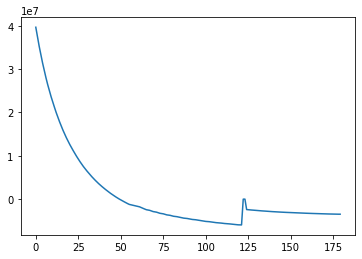

In [252]:
plt.plot(obj_relaxed_total_mult[80:])

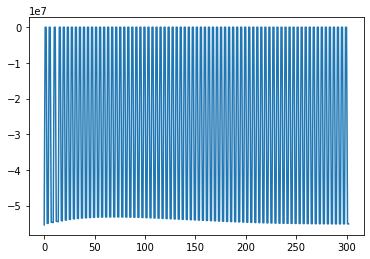

In [74]:
plt.plot(obj_relaxed_total_mult[700:])

In [8]:
u_mult = utils.load_obj('u_mult')
eta_0_mult = utils.load_obj('eta_0_mult')
eta_mult = utils.load_obj('eta_mult')
auto_param_obj_history_mult = utils.load_obj('auto_param_obj_history_mult')
auto_param_relaxed_obj_history_mult = utils.load_obj('auto_param_relaxed_obj_history_mult')

Text(0.5, 1.0, 'OAR constraints')

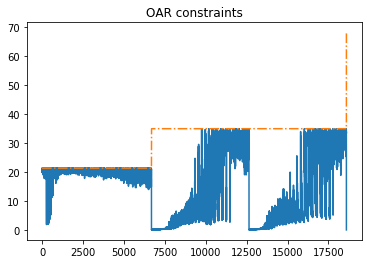

In [262]:
plt.plot(optimization_tools.constraints_all(u_mult_dv, updated_H, updated_gamma, updated_D, updated_C, tol = 0.05, verbose = 0)['Constr at u_opt'])
plt.plot(optimization_tools.constraints_all(u_mult_dv, updated_H, updated_gamma, updated_D, updated_C, tol = 0.05, verbose = 0)['actual constr'], '-.')
plt.title('OAR constraints')

In [23]:
plt.plot(optimization_tools.constraints_all(u_conv, H_conv, gamma_conv, D_conv, C_conv, tol = 0.05, verbose = 0)['Constr at u_opt'])
plt.plot(optimization_tools.constraints_all(u_conv, H_conv, gamma_conv, D_conv, C_conv, tol = 0.05, verbose = 0)['actual constr'], '-.')
plt.title('OAR constraints')

NameError: name 'u_conv' is not defined

Text(0.5, 1.0, 'OAR constraints')

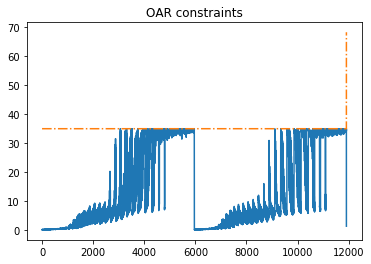

In [39]:
plt.plot(optimization_tools.constraints_all(u_mult_smoothed, H_mult, gamma_mult, D_mult, C_mult, tol = 0.05, verbose = 0)['Constr at u_opt'])
plt.plot(optimization_tools.constraints_all(u_mult_smoothed, H_mult, gamma_mult, D_mult, C_mult, tol = 0.05, verbose = 0)['actual constr'], '-.')
plt.title('OAR constraints')

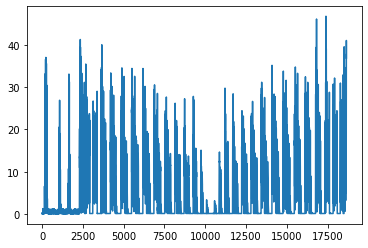

In [21]:
plt.plot(u_mult)

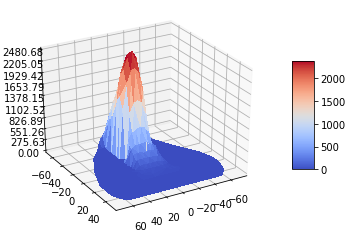

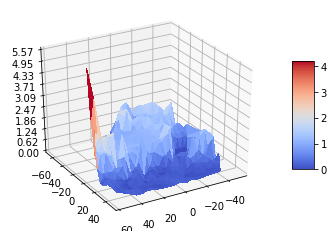

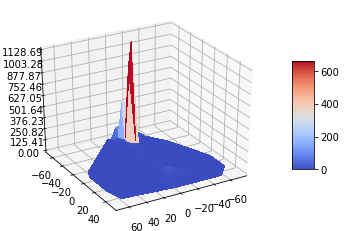

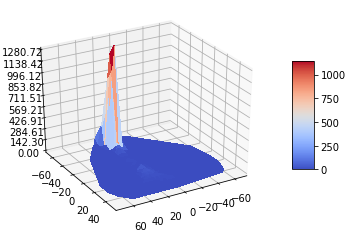

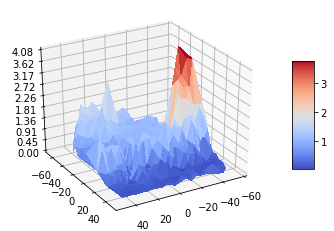

In [40]:
%matplotlib inline
for i in range(5):
    x_beam = data['beamlet_pos'][beamlet_indices[i]][:,0]
    y_beam = data['beamlet_pos'][beamlet_indices[i]][:,1]
    u_beam = u_mult_smoothed[:2289][beamlet_indices[i]]
    evaluation.plot_beam(x_beam, y_beam, u_beam)

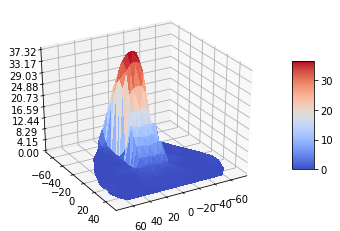

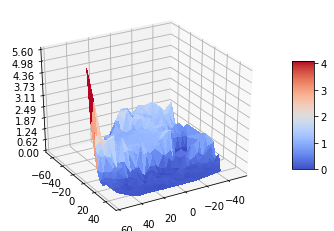

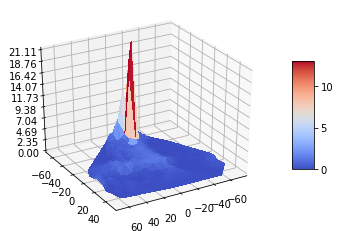

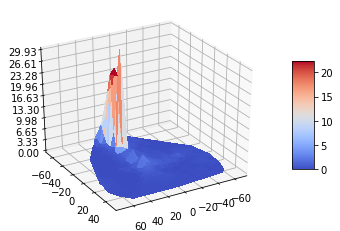

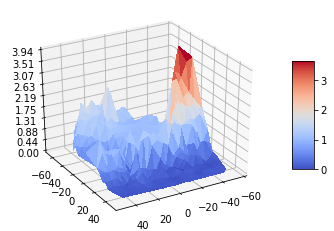

In [31]:
%matplotlib inline
for i in range(5):
    x_beam = data['beamlet_pos'][beamlet_indices[i]][:,0]
    y_beam = data['beamlet_pos'][beamlet_indices[i]][:,1]
    u_beam = u_mult_smoothed[:2289][beamlet_indices[i]]
    evaluation.plot_beam(x_beam, y_beam, u_beam)

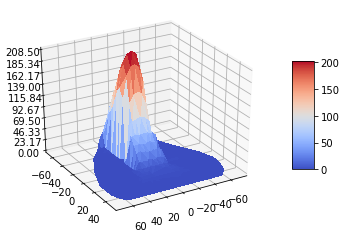

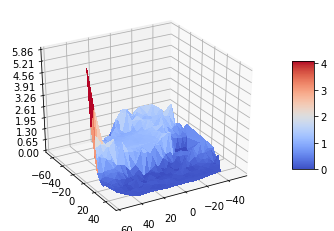

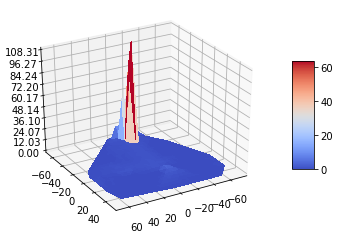

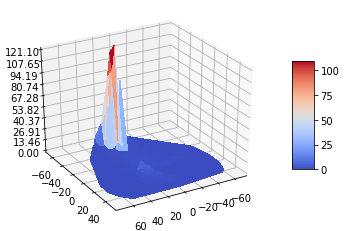

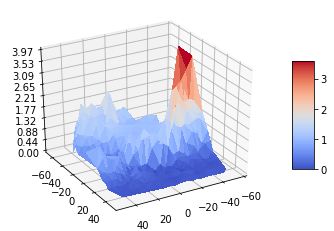

In [20]:
%matplotlib inline
for i in range(5):
    x_beam = data['beamlet_pos'][beamlet_indices[i]][:,0]
    y_beam = data['beamlet_pos'][beamlet_indices[i]][:,1]
    u_beam = u_mult_smoothed[:2289][beamlet_indices[i]]
    evaluation.plot_beam(x_beam, y_beam, u_beam)

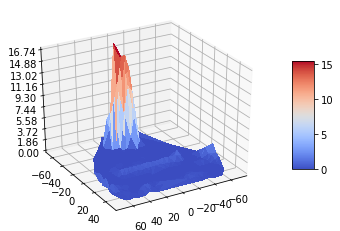

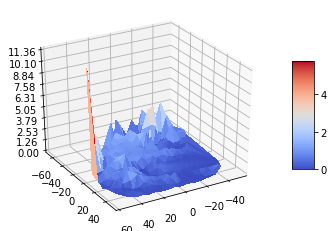

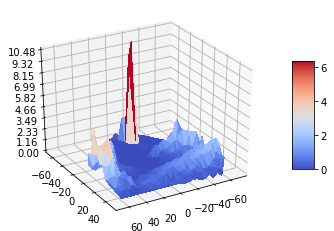

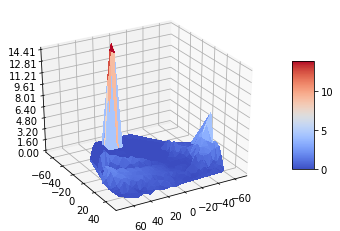

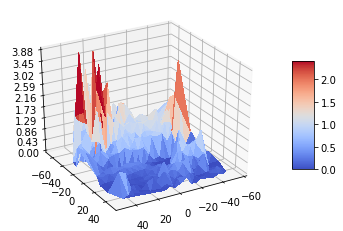

In [254]:
%matplotlib inline
for i in range(5):
    x_beam = data['beamlet_pos'][beamlet_indices[i]][:,0]
    y_beam = data['beamlet_pos'][beamlet_indices[i]][:,1]
    u_beam = u_mult_dv[:2289][beamlet_indices[i]]
    evaluation.plot_beam(x_beam, y_beam, u_beam)

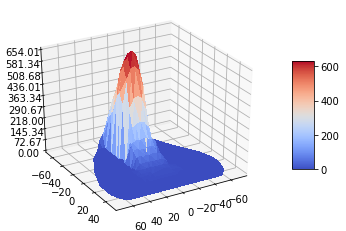

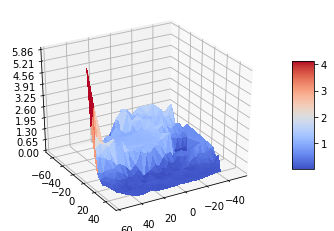

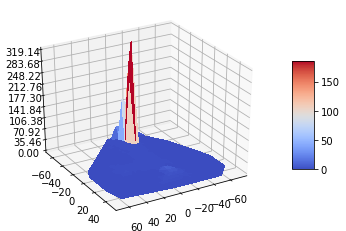

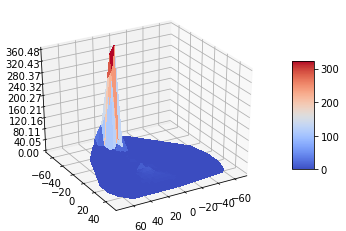

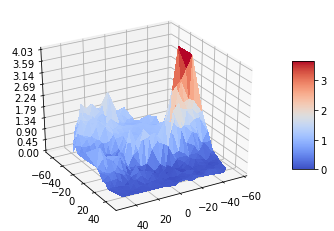

In [56]:
%matplotlib inline
for i in range(5):
    x_beam = data['beamlet_pos'][beamlet_indices[i]][:,0]
    y_beam = data['beamlet_pos'][beamlet_indices[i]][:,1]
    u_beam = u_mult[:2289][beamlet_indices[i]]
    evaluation.plot_beam(x_beam, y_beam, u_beam)

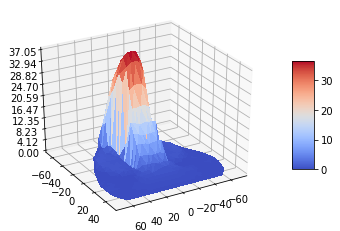

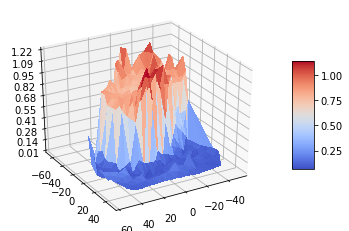

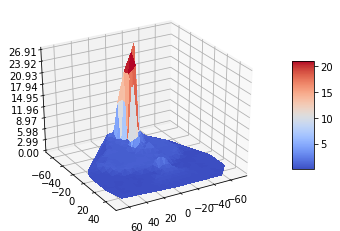

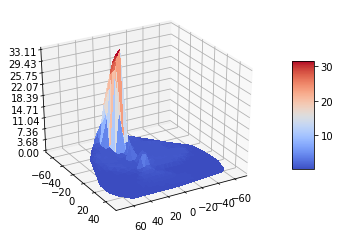

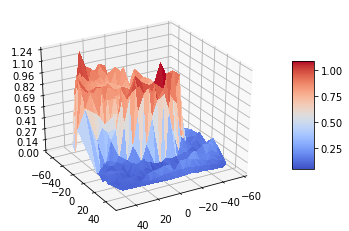

In [27]:
%matplotlib inline
for i in range(5):
    x_beam = data['beamlet_pos'][beamlet_indices[i]][:,0]
    y_beam = data['beamlet_pos'][beamlet_indices[i]][:,1]
    u_beam = u_conv[:2289][beamlet_indices[i]]
    evaluation.plot_beam(x_beam, y_beam, u_beam)

In [17]:
plt.plot(u_conv)
plt.plot(u_mult[:2289])
# plt.plot(u_conv)

NameError: name 'u_conv' is not defined

In [7]:
u_mult_with_error = np.load('u_mult_with_error.npy')

In [8]:
u_uniform = np.ones(u_mult_with_error.shape)

In [278]:
d_Target, DV_fractions_Target, organ_BE, organ_photon_dose, organ_proton_dose, organ_photon_BE_Target, organ_proton_BE_Target = evaluation.evaluation_function(u_mult_dv, [43,1], data, 'Target', Alpha, Beta, Gamma, Delta, 3000, resolution = 500)
d_LFemur, DV_fractions_LFemur, organ_BE, organ_photon_dose, organ_proton_dose, organ_photon_BE_LFemur, organ_proton_BE_LFemur = evaluation.evaluation_function(u_mult, [43,1], data, 'L Femur', Alpha, Beta, Gamma, Delta, 3000, resolution = 500)
d_RFemur, DV_fractions_RFemur, organ_BE, organ_photon_dose, organ_proton_dose, organ_photon_BE_RFemur, organ_proton_BE_RFemur = evaluation.evaluation_function(u_mult, [43,1], data, 'R Femur', Alpha, Beta, Gamma, Delta, 3000, resolution = 500)
d_Rectum, DV_fractions_Rectum, organ_BE, organ_photon_dose, organ_proton_dose, organ_photon_BE_Rectum, organ_proton_BE_Rectum = evaluation.evaluation_function(u_mult, [43,1], data, 'Rectum', Alpha, Beta, Gamma, Delta, 3000, resolution = 500)
d_Bladder, DV_fractions_Bladder, organ_BE, organ_photon_dose, organ_proton_dose, organ_photon_BE_Bladder, organ_proton_BE_Bladder = evaluation.evaluation_function(u_mult, [43,1], data, 'Bladder', Alpha, Beta, Gamma, Delta, 3000, resolution = 500)

In [105]:
# eval_list = [evaluation.evaluation_function(u_mult_with_error, [43,1], data, i, Alpha, Beta, Gamma, Delta, resolution = 50) for i in ['Target', 'L Femur', 'R Femur']]

In [112]:
organ_photon_BE_Rectum + organ_proton_BE_Rectum

array([342.00217259, 228.80453338, 160.19641381, ...,  43.65474977,
        43.88910435, 115.76017748])

In [117]:
oar_indices = np.split(np.arange(data['Aphoton'].shape[0]), np.cumsum(np.squeeze(data['num_voxels'])[1:]))[:-1]

In [148]:
organ_photon_BE_Rectum + organ_proton_BE_Rectum <= np.array(C_mult_max)[oar_indices[0]]

array([False, False, False, ..., False, False, False])

In [149]:
rectum_BE = organ_photon_BE_Rectum + organ_proton_BE_Rectum 

In [150]:
np.argsort(rectum_BE)

array([1740, 1729, 1754, ...,  531,  483,  523])

In [158]:
(rectum_BE.shape[0]//2 + rectum_BE.shape[0]%2)

887

In [168]:
# np.arange(1773)[np.argsort(rectum_BE)[:(rectum_BE.shape[0]//2 + rectum_BE.shape[0]%2)]]

In [197]:
dv_oar_names = [str(i[0]) for i in np.squeeze(data['Organ'])[1:][data['OAR_constraint_types'] == 'dose_volume']]
dv_oar_names

['Rectum', 'Bladder']

In [ ]:
np.squeeze(data['Organ'])[1:][data['OAR_constraint_types'] == 'dose_volume']

In [220]:
len(H_mult_max), len(C_mult_max)

(25279, 25279)

In [226]:
def generate_dose_volume_input(T_list_mult_max, T_mult_max, H_mult_max, alpha_mult_max, gamma_mult_max, B_mult_max, D_mult_max, C_mult_max, u_mult, N, data, Alpha, Beta, Gamma, Delta):
    oar_indices = np.split(np.arange(data['Aphoton'].shape[0]), np.cumsum(np.squeeze(data['num_voxels'])[1:]))[:-1]
    dv_oar_names = [str(i[0]) for i in np.squeeze(data['Organ'])[1:][data['OAR_constraint_types'] == 'dose_volume']]
    for i, name in enumerate(dv_oar_names):
        _,_,_,_,_, oar_photon_BE, oar_proton_BE = evaluation.evaluation_function(u_mult, N, data, name, Alpha, Beta, Gamma, Delta, 3000, resolution = 500)
        oar_BE = oar_photon_BE + oar_proton_BE
        #Take the low 50% of the voxels
        cur_oar_indices_to_max_constrain = np.argsort(oar_BE)[:(oar_BE.shape[0]//2 + oar_BE.shape[0]%2)]
#         constraint = np.array(C_mult_max)[oar_indices[0]]
        cur_oar_number = np.arange(len(oar_indices))[data['OAR_constraint_types'] == 'dose_volume'][i]
        oar_indices[cur_oar_number] = cur_oar_indices_to_max_constrain
    updated_C = [C_mult_max[i] for oar in oar_indices for i in oar]
    updated_H = [H_mult_max[i] for oar in oar_indices for i in oar]
    updated_gamma = [gamma_mult_max[i] for oar in oar_indices for i in oar]
    updated_D = [D_mult_max[i] for oar in oar_indices for i in oar]
    return oar_indices, T_list_mult_max, T_mult_max, updated_H, alpha_mult_max, updated_gamma, B_mult_max, updated_D, updated_C
        

In [227]:
a = [oar_indices, T_list_mult_max, T_mult_max, updated_H, alpha_mult_max, updated_gamma, B_mult_max, updated_D, updated_C] = generate_dose_volume_input(T_list_mult_max, T_mult_max, H_mult_max, alpha_mult_max, gamma_mult_max, B_mult_max, D_mult_max, C_mult_max, u_mult, N, data, Alpha, Beta, Gamma, Delta)

In [230]:
[len(i) for i in a[3:]]

[18596, 13564, 18596, 13564, 18596, 18596]

In [234]:
np.sum([len(i) for i in oar_indices[:2]]) +np.sum([len(i) for i in oar_indices[:]])

25281

In [235]:
len(H_mult_max)

25279

In [204]:
oar_indices

[array([   0,    1,    2, ..., 1770, 1771, 1772]),
 array([ 1773,  1774,  1775, ..., 13365, 13366, 13367]),
 array([13368, 13369, 13370, ..., 19323, 19324, 19325]),
 array([19326, 19327, 19328, ..., 25275, 25276, 25277]),
 array([25278])]

In [160]:
rectum_BE[np.argsort(rectum_BE)[:(rectum_BE.shape[0]//2 + rectum_BE.shape[0]%2)]]

array([   29.59700598,    30.41586139,    31.63325371,    33.43479078,
          33.60538142,    33.84549944,    34.00793496,    34.14487445,
          38.4688919 ,    39.17484221,    42.61854944,    42.78628645,
          43.05619274,    43.65474977,    43.88910435,    44.28036201,
          44.94653891,    45.03761556,    45.66162209,    45.67023062,
          46.04051141,    46.80262258,    47.89221581,    48.66283766,
          50.01292434,    50.72029881,    50.7399007 ,    50.87997623,
          51.35904743,    51.58707362,    51.83609102,    52.5111927 ,
          53.04442519,    54.00415811,    54.4116473 ,    54.49593317,
          54.89232815,    54.89645783,    55.22852302,    55.67356868,
          55.81353172,    56.03707635,    56.16480974,    56.46482273,
          56.83954907,    57.06068083,    57.11307825,    57.30292993,
          57.44472649,    57.47095043,    57.85920396,    58.16781941,
          59.24585014,    59.31840887,    60.00098455,    60.55023517,
      

In [140]:
# new_C1 = np.concatenate([[C_mult_max[i] for i in oar] for oar in oar_indices])
# new_C1

array([21.38888889, 21.38888889, 21.38888889, ..., 35.        ,
       35.        , 68.34722222])

In [141]:
new_C = np.array([C_mult_max[i] for oar in oar_indices for i in oar])
new_C

array([21.38888889, 21.38888889, 21.38888889, ..., 35.        ,
       35.        , 68.34722222])

In [142]:
new_C1==new_C

array([ True,  True,  True, ...,  True,  True,  True])

In [127]:
C_mult_max[]

TypeError: list indices must be integers or slices, not tuple

In [264]:
np.sum(organ_photon_BE_Target)

1706915433.0965953

In [280]:
np.sum(organ_photon_BE_Target), np.sum(organ_proton_BE_Target) 

(701670.141846684, 16760.523929836192)

In [265]:
np.sum(organ_proton_BE_Target) 

32192.75687011882

In [108]:
# eval_list[]

In [109]:
# import seaborn as sns
#683189

Text(0, 0.5, 'Fraction')

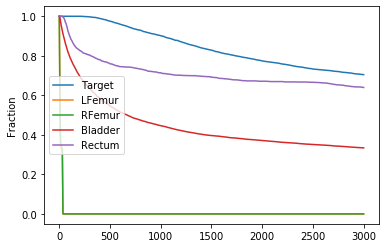

In [110]:
plt.plot(d_Target, DV_fractions_Target, label = 'Target')
plt.plot(d_LFemur, DV_fractions_LFemur, label = 'LFemur')
plt.plot(d_RFemur, DV_fractions_RFemur, label = 'RFemur')
plt.plot(d_Bladder, DV_fractions_Bladder, label = 'Bladder')
plt.plot(d_Rectum, DV_fractions_Rectum, label = 'Rectum')
plt.legend()
# plt.xlabel('Gy')
plt.ylabel('Fraction')

Text(0, 0.5, 'Fraction')

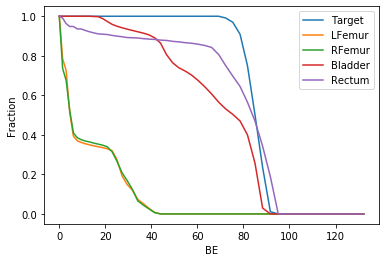

In [15]:
plt.plot(BE_conventional, DV_fractions_Target, label = 'Target')
plt.plot(BE_conventional, DV_fractions_LFemur, label = 'LFemur')
plt.plot(BE_conventional, DV_fractions_RFemur, label = 'RFemur')
plt.plot(BE_conventional, DV_fractions_Bladder, label = 'Bladder')
plt.plot(BE_conventional, DV_fractions_Rectum, label = 'Rectum')
plt.legend()
plt.xlabel('BE')
plt.ylabel('Fraction')

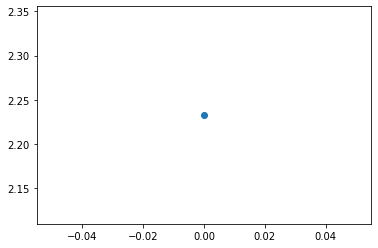

In [33]:
plt.plot(organ_photon_dose, 'o')

In [274]:
def evaluation_function_photon(u, N, data, organ_name, Alpha, Beta, Gamma, Delta, max_BE = 200, resolution = 50):
    """Constructs DVH"""
    #Target is included here:
    organ_names = [str(i[0]) for i in np.squeeze(data['Organ'])]
    organ_number = organ_names.index(organ_name)
    organ_number_no_target = organ_number-1
    len_voxels = data['Aphoton'].shape[0]
    #[:-1] because we don't wabt the last isolated voxel
    organ_indices = np.split(np.arange(len_voxels), np.cumsum(np.squeeze(data['num_voxels'])))[:-1]
    #Do this in per-voxel fashion
    photon_num = data['Aphoton'].shape[1]
    u_photon = u[:photon_num]
    u_proton = u[photon_num:]
    organ_Aphoton = data['Aphoton'][organ_indices[organ_number]]
#     organ_Aproton = data['Aproton'][organ_indices[organ_number]]
    organ_photon_dose = organ_Aphoton.dot(u_photon) #shape of this is num_voxels
#     organ_proton_dose = organ_Aproton.dot(u_proton)
    if organ_name != 'Target':
        organ_photon_BE = N[0]*Gamma[organ_number_no_target][
            0]*organ_photon_dose + N[0]*Delta[organ_number_no_target][0]*organ_photon_dose**2
#         organ_proton_BE = N[1]*Gamma[organ_number_no_target][
#             1]*organ_proton_dose + N[1]*Delta[organ_number_no_target][1]*organ_proton_dose**2
    if organ_name == 'Target':
        organ_photon_BE = N[0]*Alpha[0]*organ_photon_dose + N[0]*Beta[0]*organ_photon_dose**2
#         organ_proton_BE = N[1]*Alpha[1]*organ_proton_dose + N[1]*Beta[1]*organ_proton_dose**2
    organ_BE = organ_photon_BE #+ organ_proton_BE #shape of this is num_voxels(for this OAR/organ)
    #Now we would need to compute the RHS for different d and compare each voxel to it
    #This is a TODO for tomorrow
#     total_N = 45 #Standard practice - 45 fractions of Photons
#     d = np.linspace(0, max_, resolution)/total_N
#     if organ_name != 'Target':
#         lin = Gamma[organ_number_no_target][0]*total_N
#         quad = Delta[organ_number_no_target][0]*total_N    
#         BE_conventional = lin*d + quad*d**2
#     if organ_name == 'Target':
#         lin = Alpha[0]*total_N
#         quad = Beta[0]*total_N    
#         BE_conventional = lin*d + quad*d**2
    BE_levels = np.linspace(0, max_BE, resolution)
    #Now for each BE level find the fraction of voxels that are <=
    DV_fractions = []
    for BE_level in BE_levels:
        DV_fraction = np.sum(organ_BE >= BE_level)/len(organ_BE)
        DV_fractions.append(DV_fraction)
    #Note that organ_BE and organ_photon_BE should be the same    
    print('organ_BE: ', organ_BE)
    print('organ_photon_BE: ', organ_photon_BE)
    return BE_levels, DV_fractions, organ_BE, organ_photon_dose, organ_photon_BE